In [1]:
#Import packages
import pandas as pd
import numpy as np
import glob
import re
import string
import codecs
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dateutil.parser import parse
from datetime import datetime
from matplotlib_venn import venn2

In [2]:
#Code borrowed and adapted from George Chen, Carnegie Mellon University#
#Define function to remove punctuation and whitespace, and lowercase all text
def makeWordList(str_object):
    
    corpus_text = str(str_object)
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

# Data Pre-Processing

## Religion Pre-Processing

In [ ]:
#Read in headlines dataset
data = pd.read_csv("india-news-headlines.csv")

In [ ]:
#Split dataset for upload to GitHub
india_news_headlines_1 = data.iloc[0:593984, :]
india_news_headlines_2 = data.iloc[593984:1187969, :]
india_news_headlines_3 = data.iloc[1187969:1781953, :]
india_news_headlines_4 = data.iloc[1781953:2375938, :]
india_news_headlines_5 = data.iloc[2375938:2969922, :]

In [ ]:
#Write split data to csv files for upload
india_news_headlines_1.to_csv("india-news-headlines-1.csv", index=False)
india_news_headlines_2.to_csv("india-news-headlines-2.csv", index=False)
india_news_headlines_3.to_csv("india-news-headlines-3.csv", index=False)
india_news_headlines_4.to_csv("india-news-headlines-4.csv", index=False)
india_news_headlines_5.to_csv("india-news-headlines-5.csv", index=False)

In [ ]:
#define religious vocabulary for creating religion-related datasets
religious_vocab = ['religion', 'religious', 'hindu', 'hinduism',
                  'islam', 'muslim', 'christianity', 'christian', 'sikh',
                  'sikhism', 'temple', 'mosque', 'church', 'divine', 'god', 'gods',
                  'prayer', 'prayers', 'priest', 'clergy', 'imam', 'monk', 'dharma',
                  'vedas', 'worship', 'worshippers', 'worshipers' 'worshipper', 'worshiper', 'ayodhya',
                   'babri', 'hindutva','lynching','ethnic', 'purity','nationalism', 'nationalist',
                   'rss', 'sangh'
                  ]

In [ ]:
#Split headline data on 2014 election into pre and post sets
data_pre = data[data['publish_date'] <= 20140501]
data_post = data[data["publish_date"] > 20140501]

In [ ]:
#Generate religious flags for pre- and post-election datasets
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
pre_mask = []
for headline in np.array(data_pre["headline_text"]):
    parsed = nlp(headline)
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    pre_mask.append(religious_flag)
        
post_mask = []
for headline in np.array(data_post["headline_text"]):
    parsed = nlp(headline)
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    post_mask.append(religious_flag)

In [ ]:
#Generate religious datasets
pre = pd.Series(pre_mask)
religious_pre = data_pre[pre.values]
post = pd.Series(post_mask)
religious_post = data_post[post.values]

In [ ]:
#Write religious datasets to csv files
religious_pre.to_csv("religious_headlines_pre.csv", index=False)
religious_post.to_csv("religious_headlines_post.csv", index=False)

In [ ]:
#Import parliamentary Q&A dataset
li = []

for file in glob.glob('./india_analysis_UDA/Parliament_Qs/rajyasabha_questions_and_answers_*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
parliament_qs = pd.concat(li, axis = 0, ignore_index = True)

In [ ]:
#Apply religion filter to parliamentary dataset
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
answer_mask = []
for answer in np.array(parliament_qs["answer"]):
    parsed = nlp(str(answer))
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    answer_mask.append(religious_flag)

In [ ]:
#Generate religious parliamentary answer dataset
answer_mask = pd.Series(answer_mask)
religious_answers = parliament_qs[answer_mask.values]

In [ ]:
#Split religious parliamentary dataset based on when the new government came into office
answers_pre_mask = []
for date in religious_answers['answer_date'].to_numpy():
    if parse(date) < parse('2014.05.26'):
        answers_pre_mask.append(True)
    else:
        answers_pre_mask.append(False)
answers_pre_mask = pd.Series(answers_pre_mask)
religious_answers_pre = religious_answers[answers_pre_mask.values]
religious_answers_post = religious_answers[~answers_pre_mask.values]
religious_answers_pre.to_csv("religious_answers_pre.csv", index=False)
religious_answers_post.to_csv("religious_answers_post.csv", index=False)

## Full Datasets Pre-Processing

In [3]:
#Create single parliament_qs dataframe with all question data
li = []

for file in glob.glob('./Parliament_Qs/rajyasabha_questions_and_answers_*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
parliament_qs = pd.concat(li, axis = 0, ignore_index = True)

In [4]:
#Process parliamentary answers
processed_answers = []

for str_object in list(parliament_qs["answer"]):
    processed_answers.append(makeWordList(str_object))

In [5]:
#Import headlines dataset
li = []

for file in glob.glob('./india_headlines_data/*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
headlines_raw = pd.concat(li, axis = 0, ignore_index = True)

In [6]:
#Process headlines, delete headlines object, sample 10% of processed headlines
import random
processed_headlines = []
random.seed(42)
headlines = random.sample(list(headlines_raw["headline_text"]), round(len(headlines_raw)/10))
                          
for str_object in headlines:
    processed_headlines.append(makeWordList(str_object))

In [7]:
#Import religious headline pre- and post-election datasets
li = []

for file in glob.glob('./india_headlines_data_pre/religious*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_pre = pd.concat(li, axis = 0, ignore_index = True)

li = []

for file in glob.glob('./india_headlines_data_post/religious*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_post = pd.concat(li, axis = 0, ignore_index = True)

In [8]:
#Process religious headlines
processed_religious_headlines_pre = []

for str_object in list(religious_headlines_pre["headline_text"]):
    processed_religious_headlines_pre.append(makeWordList(str_object))
    
processed_religious_headlines_post = []

for str_object in list(religious_headlines_post["headline_text"]):
    processed_religious_headlines_post.append(makeWordList(str_object))

# Dataset Description and Exploration

Text(0, 0.5, 'Quantity')

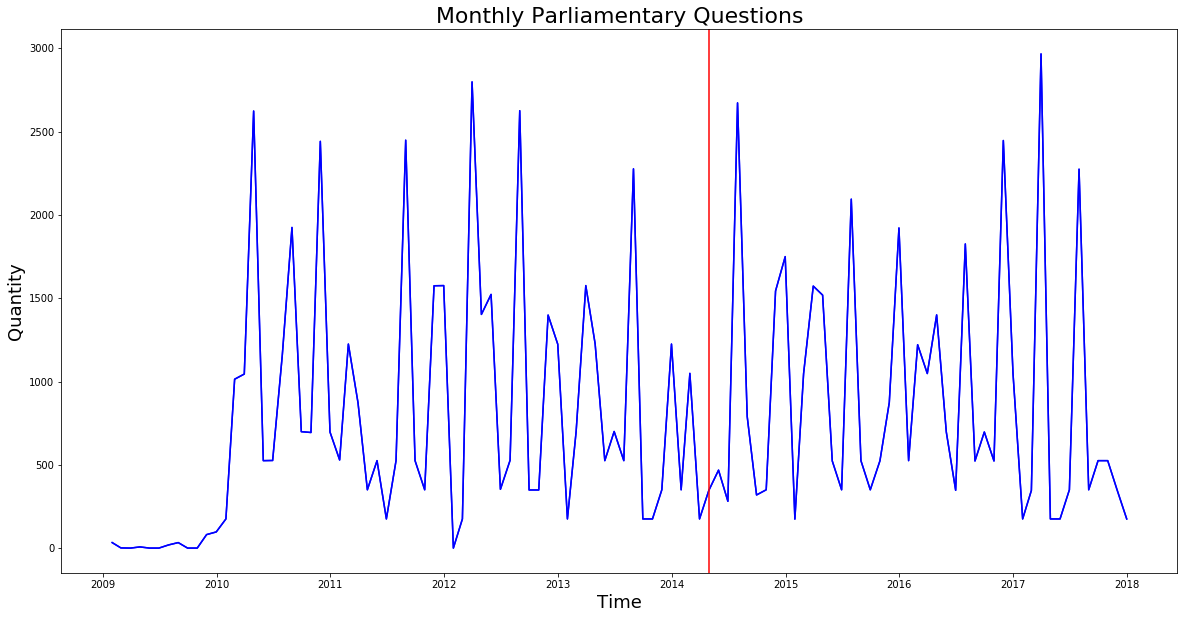

In [17]:
#Process Parliament Q&A dataset, aggregating by month and producing a plot of the date distribution
answer_dates = pd.DataFrame(pd.to_datetime(parliament_qs["answer_date"]))
final_answer_dates = []
for date in answer_dates["answer_date"]:
    if isinstance(date, datetime):
        final_answer_dates.append([date, 1])
final_answer_dates = pd.DataFrame(final_answer_dates)
#final_answer_dates.reset_index().set_index(0)

plt.figure(figsize=(20,10))
agg = final_answer_dates.resample('M', on=0).count()
plt.plot(agg, c='blue')
election = parse("2014-05-01")
plt.axvline(x=election, c='red')
plt.title("Monthly Parliamentary Questions", size=22)
plt.xlabel("Time", size = 18)
plt.ylabel("Quantity", size = 18)

Text(0, 0.5, 'Quantity')

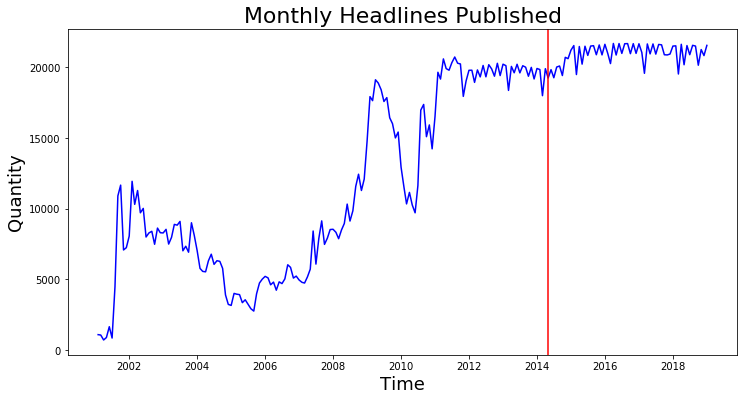

In [18]:
#Process headlines dataset, aggregating by month and producing datetime plot
headline_dates = pd.DataFrame(pd.to_datetime(headlines_raw["publish_date"]))
final_headline_dates = []
for date in list(headlines_raw["publish_date"]):
    datetime = datetime.strptime(str(date), "%Y%m%d")
    final_headline_dates.append(datetime)
final_headline_dates = pd.DataFrame(final_headline_dates)
#plot
plt.figure(figsize=(12,6))
agg = final_headline_dates.resample('M', on=0).count()
plt.plot(agg, c='blue')
election = parse("2014-05-01")
plt.axvline(x=election, c='red')
plt.title("Monthly Headlines Published", size=22)
plt.xlabel("Time", size = 18)
plt.ylabel("Quantity", size = 18)

# Sentiment Analysis on Religion Datasets

# Topic Modeling - Religious Headlines

In [20]:
#Use TfidfVectorizer to transform religious headlines
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_pre = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_pre_fit = vectorizer_pre.fit(processed_religious_headlines_pre)
X_rel_headlines_pre = vectorizer_pre.fit_transform(processed_religious_headlines_pre).toarray()

vectorizer_post = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_post_fit = vectorizer_post.fit(processed_religious_headlines_post)
X_rel_headlines_post = vectorizer_post.fit_transform(processed_religious_headlines_post).toarray()

In [21]:
#Generate seperate topic models for pre and post
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda_rel_headlines_pre = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_rel_headlines_pre.fit(X_rel_headlines_pre)

lda_rel_headlines_post = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_rel_headlines_post.fit(X_rel_headlines_post)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [22]:
#Display top words for topics for pre- and post-election topics
words = list(rel_headlines_pre_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_rel_headlines_pre.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic for pre-election relgious headlines')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

words = list(rel_headlines_post_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_rel_headlines_post.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic for post-election relgious headlines')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 10 words per topic and their probabilities within the topic for pre-election relgious headlines

[Topic 0]
gets : 0.3325878908343633
vhp : 0.1410741139730405
land : 0.09764653418812733
rain : 0.07304272493430007
women : 0.06716153659901956
polls : 0.06155488657925728
high : 0.06152229777309942
churches : 0.04688881030527306
hindus : 0.04190856687229721
offer : 0.04053579900361241

[Topic 1]
monk : 0.09765610426785298
babri : 0.08782965075859098
gujarat : 0.08167533787612587
centre : 0.07756836684415125
rss : 0.0736208801311144
day : 0.07045636329665927
pakistan : 0.06295241149101867
body : 0.05652299472458706
modi : 0.056406034055761056
today : 0.053136787481863235

[Topic 2]
body : 0.24650077884660038
leader : 0.19598466160003897
demand : 0.07515014473444322
prayer : 0.07069654233678867
court : 0.06340698526049049
set : 0.0614349715701121
christian : 0.05403263248965024
new : 0.044979946185935954
party : 0.038278258138742534
state : 0.03787685008210023

[Topic 3]
as

# Topic Modeling - Headlines

In [23]:
#Use TfidfVectorizer to transform headlines
##Memory intensive##
from sklearn.feature_extraction.text import TfidfVectorizer
headline_vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
headlines_fit = headline_vectorizer.fit(processed_headlines)
X_headlines = headline_vectorizer.fit_transform(processed_headlines).toarray()

In [24]:
#Generate 10 topics for headlines
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda_headlines = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_headlines.fit(X_headlines)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [25]:
#View top 20 words for each topic in order to characterize
words = list(headlines_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_headlines.components_])
num_top_words = 20

print('Displaying the top 20 words per topic and their probabilities within the topic...')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
labour : 0.03860330906379886
mission : 0.03374031671009788
course : 0.032462592063320285
cheating : 0.02674135554586314
filed : 0.02570318762380012
education : 0.01826181535798846
cop : 0.017738767759230903
scare : 0.014018263958041628
chhattisgarh : 0.013574345666579408
bar : 0.013280687501206163
demolition : 0.013279851005599978
special : 0.012612841793144087
rescued : 0.012484319189964543
nitish : 0.012426966066449644
tea : 0.011100287764688058
programme : 0.01098458651119928
does : 0.010733813709688816
seven : 0.010671161737769101
district : 0.010573515056109362
left : 0.010396358391977568

[Topic 1]
bollywood : 0.05652672305509811
mc : 0.020877611782112865
chinese : 0.01951978015539641
cell : 0.01862620140313285
fuel : 0.018525507570669772
common : 0.0182746225720331
fears : 0.018235411934387834
caught : 0.018131542869644003
kochi : 0.017012086919733094
trouble : 0.016547194568394756
rajna

# Applying Headlines Topics to Parliament Data

In [26]:
#Remove words in parliament data that don't exist within headlines data
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
processed_answers_for_headline_topics = []
out_of_topics_mask = []
in_topics_mask = []
for answer in np.array(parliament_qs["answer"]):
    parsed = nlp(str(answer))
    processed_answer_list = []
    out_of_topics_count = 0
    in_topics_count = 0
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in headlines_fit.vocabulary_:
                processed_answer_list.append(token_lemma)
                in_topics_count += 1
            else:
                out_of_topics_count += 1
    processed_answer_str = " ".join(processed_answer_list)
    processed_answers_for_headline_topics.append(processed_answer_str)
    out_of_topics_mask.append(out_of_topics_count)
    in_topics_mask.append(in_topics_count)

In [27]:
#Transform the parliamentary answers using the vectorizer used for the headlines
X_answers_for_headline_topics = headline_vectorizer.transform(processed_answers_for_headline_topics[:10000]).toarray()

In [28]:
#Generate topic distributions for the headlines to the parliamentary answers
answers_distribution_of_headline_topics = lda_headlines.transform(X_answers_for_headline_topics)

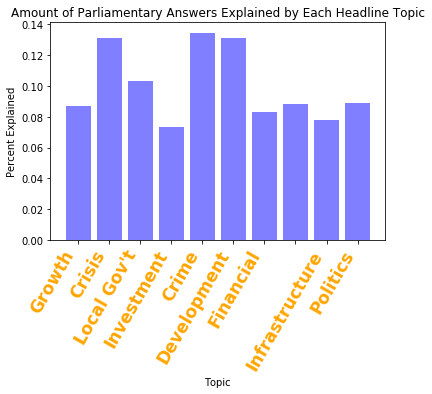

In [29]:
#Sum amount explained per topic, normalize, and plot
sum_explained_per_topic = []
for i in range(num_topics):
    sum_explained_per_topic.append(sum(answers_distribution_of_headline_topics[:,i]))
per_explained_per_topic = []
for i in range(num_topics):
    x = sum_explained_per_topic[i]/sum(sum_explained_per_topic)
    per_explained_per_topic.append(x)
#plot
plt.bar(range(10), per_explained_per_topic, facecolor='blue', alpha=0.5)
plt.xlabel('Topic')
plt.ylabel('Percent Explained')
labs = ('Growth', 'Crisis', "Local Gov't", 'Investment', 'Crime', 'Development', 'Financial', '', 'Infrastructure', 'Politics')
plt.xticks(np.arange(10), labs, color='orange', rotation=60, fontweight='bold', fontsize='17', horizontalalignment='right')
plt.title('Amount of Parliamentary Answers Explained by Each Headline Topic')
plt.show()

3495 908 535


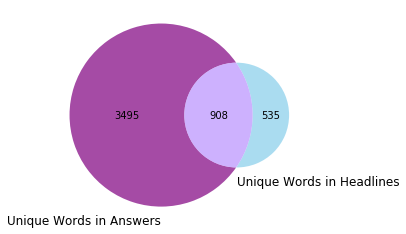

In [31]:
#Visualize the amount of words unique to each dataset and shared among the datasets
in_both = 0
in_answers_only = 0
in_headlines_only = 0

#Use TfidfVectorizer to transform parliamentary answers
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
answers_fit = vectorizer.fit(processed_answers)
X_answers = vectorizer.fit_transform(processed_answers).toarray()

for word in answers_fit.vocabulary_:
    if word in headlines_fit.vocabulary_:
        in_both += 1
    else:
        in_answers_only += 1
for word in headlines_fit.vocabulary_:
    if word not in answers_fit.vocabulary_:
        in_headlines_only += 1
print(in_answers_only, in_both, in_headlines_only)
venn2(subsets = (in_answers_only, in_headlines_only, in_both), set_labels = ("Unique Words in Answers", "Unique Words in Headlines"),
      set_colors=('purple', 'skyblue'), alpha = 0.7);

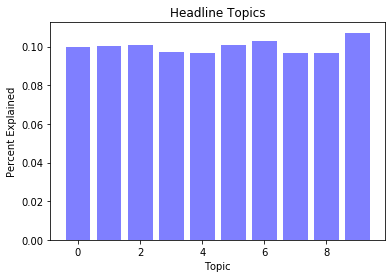

In [32]:
#Plot topic distribution for the headlines dataset itself to establish baseline
X_headlines_sample = X_headlines[np.random.choice(X_headlines.shape[0], 10000, replace=False)]
headline_topic_distribution = lda_headlines.transform(X_headlines_sample)

sum_explained_per_topic = []
for i in range(num_topics):
    sum_explained_per_topic.append(sum(headline_topic_distribution[:,i]))
per_explained_per_topic = []
for i in range(num_topics):
    x = sum_explained_per_topic[i]/sum(sum_explained_per_topic)
    per_explained_per_topic.append(x)

plt.bar(range(10), per_explained_per_topic, facecolor='blue', alpha=0.5)
plt.xlabel('Topic')
plt.ylabel('Percent Explained')
plt.title('Headline Topics')
plt.show()